# Product Recommendation Systems - Assignment

### 1. Load and understand the data

#### 1.1 Import required Python packages 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # matplotlib.pyplot plots data
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)

from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

#### 1.2 Set Display settings

In [2]:
from IPython.core.display import HTML, display
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
div.text_cell_render {
font-family: "Trebuchet MS", "Helvetica", sans-serif;
}
</style>
""")

#### 1.3 Read data set and print the shape of the data

In [3]:
# ignoring the "Timestamp" column when loading the dataset
pdata = pd.read_csv("ratings_Electronics.csv", header=None,usecols=[0,1,2] )
print("Shape of the data set is ",pdata.shape)
pdata.columns = ['userId','productId','ratings']
pdata.head(10)

Shape of the data set is  (7824482, 3)


,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
5,A1QGNMC6O1VW39,0511189877,5.0
6,A3J3BRHTDRFJ2G,0511189877,2.0
7,A2TY0BTJOTENPG,0511189877,5.0
8,A34ATBPOK6HCHY,0511189877,5.0
9,A89DO69P0XZ27,0511189877,5.0


####  <font color='blue'>There are 7824482 rows in the dataset. There are 4 columns but we have omitted the "timestamp" column while reading. So, there are 3 columns "userId", "productId" and "ratings" in the dataframe.</font>

####  1.4 List data types of all attributes

In [4]:
pdata.dtypes

userId        object
productId     object
ratings      float64
dtype: object

####  <font color='blue'>There are 2 object variables "userId" and "productId. There is 1 numeric variable "ratings"</font>

#### 1.5 Check for missing values

In [5]:
n_missingvalues=pdata.isnull().values.sum() + pdata.isna().values.sum()

if (n_missingvalues ==0):
    print ("There are no missing values in the data")
else:
    print ("There are",n_missingvalues,"missing values in the data")

There are no missing values in the data


#### <font color='blue'>There are no missing values (null/NaN) across the data</font>

#### 1.6 List a 5-point summary & mean of numerical attributes

In [6]:
pdata.describe().loc[['min','25%','50%','mean','75%','max','std']].T

,min,25%,50%,mean,75%,max,std
ratings,1.0,3.0,5.0,4.012337,5.0,5.0,1.38091


#### <font color='blue'>The following observations can be made from the 5-point summary<br><br><li>Every user in the dataset has rated atleast one product</li><br><li>The minimum and maximum ratings for a product are 1 and 5 respectively</li><br><li>The mean user rating of the products is 4.01 and the standard deviation is 1.38</li><br><li>Q1 : 25% of all ratings are or below 3</li><br><li>Q2: 50% of the data points are or less than 5</li><br><li>Q3: 75% of the data points are or less than 5</font>

#### 1.7 Analysis using Distribution Plots 

In [7]:
print("The number of Unique Users:{} and number of unique products:{} in our ecommerce site".format(
    len(pdata['userId'].unique()),len(pdata['productId'].unique())))

The number of Unique Users:4201696 and number of unique products:476002 in our ecommerce site


#### <font color='blue'>There are 4201696 unique users and 476002 unique products in the data set. In order to make the data set denser, we will subset it to retain only users who have given 50+ ratings in the following sections</font>

#### <font color='blue'>We compute the count for each rating 1.0-5.0 and also the corresponding percentage</font>

ratings
1.0     901765
2.0     456322
3.0     633073
4.0    1485781
5.0    4347541
Name: ratings, dtype: int64
ratings
1.0    12.0
2.0     6.0
3.0     8.0
4.0    19.0
5.0    56.0
Name: ratings, dtype: float64
Skewness of data: -1.21


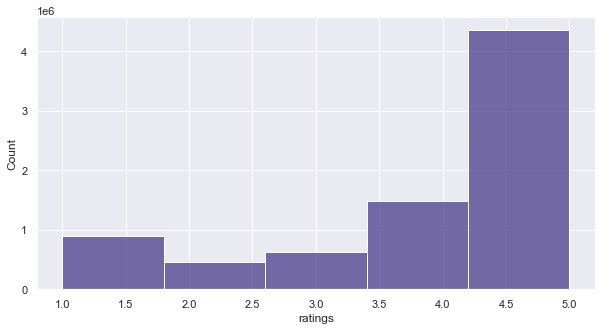

In [8]:
# count of each rating
rating_groups = pdata.groupby('ratings')['ratings'].count()
print(rating_groups)

# Percentage of overall dataset
print(round(100*rating_groups/pdata['ratings'].count(),0))

# Compute skewness
print("Skewness of data:",round(pdata['ratings'].skew(),2))

# Plot counts
plt.figure(figsize=(10,5))
sns.histplot(data=rating_groups,x=pdata['ratings'],bins=5,color='darkslateblue');

<AxesSubplot:xlabel='ratings', ylabel='Density'>

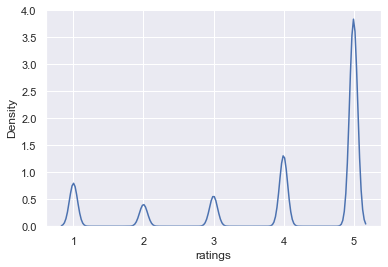

In [9]:
sns.kdeplot(data=rating_groups,x=pdata['ratings'])

###### <font color='blue'>The following observations can be made from the distribution plot<br><br><li>56% of the provided ratings are 5.0, indicating that the product is highly liked by the users</li><br><li>If we consider ratings 4.0 and 5.0, 75% of the ratings fall in this set. This reinforces the above point.</li><br><li>About 25% of the ratings are 1.0, 2.0, 3.0</li><br><li>The distribution is multi-modal with distinct peaks at each rating value</li><br><li>The distribution is negatively skewed with a prominent left tail</li></font>

#### Finding out the product that received maximum ratings and the user who has rated the maximum number of products

In [10]:
user_rt=pdata.groupby('userId')['ratings'].count()
freq_user=pdata['userId'].value_counts().idxmax()

prod_rt=pdata.groupby('productId')['ratings'].count()
freq_prod=pdata['productId'].value_counts().idxmax()

print(user_rt.max(), freq_user)
print(prod_rt.max(), freq_prod)

520 A5JLAU2ARJ0BO
18244 B0074BW614


#### <font color='blue'>User "A5JLAU2ARJ0BO" has provided 520 ratings, which is the highest across all users. Product "B0074BW614" has received 18244 ratings, which is the highest across all rated products</li></font>

### 2. Subset the dataset

#### <font color='blue'>In this section, we will extract a subset of the dataset that has only users who have provided more than 50 ratings. This reduces the dataset size but has the following advantages<br><br><li>It will <font color='#E74C3C'>reduce computatational complexity</font> of the various recommendation engines that can be used such as Matrix Factorization, Collaborative Filtering, given that the data set is fairly large in size (~300 MB) for a local machine</li><br><li>A recommendation system based on users with more ratings is <font color='#E74C3C'>likely to be more reliable</font>. This is because, the preference of users who rated lesser products may not be representative of their overall preferences</li></font>

In [ ]:
pdata_sub=pdata.join(pdata.groupby('userId')['ratings'].count(),on='userId',rsuffix='_user_count')
pdata_sub.head()

In [ ]:
pdata_sub = pdata_sub[pdata_sub['ratings_user_count']>=50]
print("Shape of the subsetted data:",pdata.shape)
print("Shape of the subsetted data:",pdata_sub.shape)

print("Total # of rows in the original dataset:",pdata.shape[0])
print("# of rows in the subset:",pdata_sub.shape[0])
print("% of subsetted rows:",round(100*pdata_sub.shape[0]/pdata.shape[0],2))

#### <font color='blue'>Of the 7824482 data points, 125871 pertain to users who have given rated 50 or more products. This represents about 1.6% of the overall data set. The data set is less sparser and denser, and will provide the advantages mentioned in the notes above</font>

#### After subsetting the data, let us look at the rating counts, percentages and count plot.

In [ ]:
rating_groups = pdata_sub.groupby('ratings')['ratings'].count()
print(rating_groups)

print(round(100*rating_groups/pdata_sub['ratings'].count(),0))

print("Skewness of data:",round(pdata_sub['ratings'].skew(),2))

plt.figure(figsize=(15,10))
sns.histplot(data=rating_groups,x=pdata_sub['ratings'],bins=5,color='darkslateblue');

In [ ]:
sns.kdeplot(data=rating_groups,x=pdata_sub['ratings'])

#### <font color='blue'>The following observations can be made from the distribution plot of the subsetted data<br><br><li>The distribution remains similar to the original dataset for ratings 4,5</li><br><li>The distributions pertaining to ratings {1,2,3} are different than the full dataset</li><br><li>The left skewness of the dataset increased from -1.21 to -1.56</li><br></font>

### 3. Popularity Recommendation Model

#### The Popularity based recommendation works by recommending products rated highly by most users. It is not a personalized recommendation and does not suffer from cold-start problem

In [ ]:
#We will add a column called "ratings_product_count", that provides the number of ratings given to each product. 
#This is required to recommend based on product popularity
pdata_sub = pdata_sub.join(pdata_sub.groupby('productId')['ratings'].count(),on='productId',rsuffix='_product_count')

#Create 2 copies, one each for product-based popularity and user-based popularity
pdata_sub_prc = pdata_sub.copy(deep=True)
pdata_sub_ur = pdata_sub.copy(deep=True)

#### Method 1 : Finding out the popularity based on the number of ratings received by each product in the dataset and listing down the top 10 popular products

In [ ]:
pdata_sub_prc = pdata_sub_prc.groupby('productId')['ratings','ratings_product_count'].mean().sort_values(by='ratings_product_count',ascending=False)
pdata_sub_prc.head(10)

#### Method 2 : Finding out the popularity based on the the user ratings received by each product in the dataset and listing down the top 10 popular products

In [ ]:
pdata_sub_ur = pdata_sub_ur.groupby('productId')['ratings','ratings_product_count'].mean().sort_values(by='ratings',ascending=False)
pdata_sub_ur.head(10)

#### <font color='blue'><li>There are 2 methods that can be used to provide popularity-based recommendations - based on # of ratings received by each product and the actual rating received by each product</li><br><li>Method 1 - based on # of ratings received is a better approach , because more ratings for the same product by different users is a good measure of popularity</li></font>

#### Creating a Product to Rating matrix for final recommendation

In [ ]:
# For each product, obtain the count of all 5 ratings by unstacking the dataset
unstacked = pdata_sub.groupby('productId')['ratings'].value_counts().unstack().fillna(0)

# Sort the unstacked dataset in descending order of # of ratings received. Display the split of # of ratings across ratings 1-5.
#The top 10 recommnded products are shown below
pop_recos = pd.merge(pdata_sub_prc,unstacked,on='productId')
pop_recos.nlargest(10,'ratings_product_count')

#### Summary of Popularity based recommendation
The top 10 products based on the number of ratings received was computed and recommended
#### <font color='teal'>Advantages<br><br> 1. The main advantage is the simplicity of the algorithm<br><br>2. Since it does not consider any user related attributes, the model is not impacted by cold-start problem<br><br>3. As the model involves only sorting of the data frame, it is not computationally expensive</font> 
#### <font color='IndianRed'>Disadvantages<br><br>1. The recommendations are not personalized to users and remain at a generic level</font> 

### 4. Collaborative Filtering

#### <font color='blue'>Collaborative Filtering approaches overcome the disadvantage of Popularty and Content based recommendations. We will make product recommendations using the following models<br><br><li>Matrix Factorization</li><br><li>User-based Collaborative filtering</li><br><li>Product-based Collaborative filtering</li></font>

#### <font color='blue'>4.1. Matrix Factorization</font>

#### Matrix Factorization is a technique that uses prior ratings provided to products by users in order to predict the ratings that a user may provide for a given product. We will use SVD (Singular Value Decomposition) from Surprise Library to implement this.

In [ ]:
reader=Reader(rating_scale=(1.0, 5.0))

# Create a matrix from the dataset
pdata_mf=Dataset.load_from_df(pdata_sub[['userId','productId','ratings']],reader)

#Split the dataset into training and testing sets
from surprise.model_selection.split import train_test_split
train,test=train_test_split(pdata_mf,test_size=0.3,random_state=42)

In [ ]:
model_mf = SVD()
model_mf.fit(train)
mf_pred = model_mf.test(test)
mf_pred

In [ ]:
from collections import defaultdict
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

The above function is called in the Summary section to display the top 5 recommended products for Popularity based model

#### Evaluating the model

In [ ]:
print("RMSE: ",round(accuracy.rmse(mf_pred,verbose=False),2))
print("MAE: ",round(accuracy.mae(mf_pred,verbose=False),2))

#### <font color='blue'>For user-based and product-based collaborative filtering approaches, we will use K-Nearest Neighbours method of making recommendations based on the preferences of the nearest similar users or products. This is implemented using the functon KNNWithMeans. Similarity between users (or products) is calculated for each user (or product) based on distance - which can either be Cosine Similiarity or Pearson Correlation</font>

#### <font color='blue'>4.2. User-based Collaborative Filtering</font>

In this approach, product recommendations are provided to a <font color='#D35400'>given user</font> based on his/her <i>similarity</i> with neighbours in the cluster. Similarity is established either through cosine similarity or pearson correlation coefficient. In this exercise, we will use Cosine Similarity 

In [ ]:
# Before loading the dataset, we are trimming it to 50000. 
# Using values of more than this resulted in memory issues in my local machine and hence limiting it to 50000
pdata_sub = pdata_sub.head(50000)
pdata_cf=Dataset.load_from_df(pdata_sub[['userId','productId','ratings']],reader)

# Split the data into train/test
train,test =train_test_split(pdata_cf,test_size=0.3, random_state=42)

#### <font color='blue'>Based on GridSearch performed in Section 9, we have chosen <font color='#9B59B6'>K=50</font> and <font color='#9B59B6'>Cosine Similarity</font> as the distance measure</font>

Note : K comes out as 40 or 50 in different runs of GridSearch.

In [ ]:
cf_k = 50
model_ubcf = KNNWithMeans(k=cf_k,sim_options={'name': 'cosine', 'min_support': 5, 'user_based': True,'k':5},verbose= True,c=3)
model_ubcf.fit(train)
pred_ubcf=model_ubcf.test(test)
pred_ubcf

#### Evaluating the model

In [ ]:
print("RMSE:",round(accuracy.rmse(pred_ubcf,verbose=False),2))
print("MAE:",round(accuracy.mae(pred_ubcf,verbose=False),2))

#### 4.3. Product-based Collaborative Filtering

In this approach, recommendations are provided to a user based on how similar the <font color='#D35400'><i>given product</i></font> is with its product neighbours within the cluster. Similarity is established either through cosine similarity or pearson correlation coefficient. In this exercise, we will use Cosine Similarity.

From an implementation perspective, it is similar to user-based collaborative filtering - except that we set the parameter <font color='#D35400'><i>user-based: False</i></font>

In [ ]:
model_pbcf = KNNWithMeans(k=cf_k,sim_options={'name': 'cosine', 'min_support': 5, 'user_based': False,'k':5},verbose= True,c=3)
model_pbcf.fit(train)
pred_pbcf=model_pbcf.test(test)
pred_pbcf

#### Evaluating the model

In [ ]:
print("RMSE:",round(accuracy.rmse(pred_pbcf,verbose=False),2))
print("MAE:",round(accuracy.mae(pred_pbcf,verbose=False),2))

### 5. Summary

#### 5.1. Popularity based recommendation - Top 5 Recommendations

In [ ]:
pop_recos.nlargest(5,'ratings_product_count')

#### 5.2 Matrix Factorization - Top 5 Recommendations

In [ ]:
top_n = top_n = get_top_n(mf_pred,n=5)
top_n

#### 5.3. User-based Collaborative Filtering - Top 5 Recommendations

In [ ]:
def get_top_user(pred,n=5):
  top_n=defaultdict(list)
  for uid,iid,true_r,est,_ in pred:
    top_n[uid].append((iid,est))
  for uid,user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1],reverse=True)
    top_n[uid]=user_ratings[:n]
  return top_n

top_users=get_top_user(pred_ubcf,n=5)

# For each user Print the recommended items
for uid, user_ratings in top_users.items():
    print(uid, [iid for (iid, _) in user_ratings])


#### 5.4. Product-based Collaborative Filtering - Top 5 Recommendations

In [ ]:
def get_top_product(pred,n=5):
  top_n=defaultdict(list)
  for uid,iid,true_r,est,_ in pred:
    top_n[uid].append((iid,est))
  for uid,user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1],reverse=True)
    top_n[uid]=user_ratings[:n]
  return top_n

top_items=get_top_product(pred_pbcf)

# For each user Print the recommended items
df_item=pd.DataFrame()
for uid, user_ratings in top_items.items():
    print(uid, [iid for (iid, _) in user_ratings])

#### 5.5. Performance comparison

<table style="width:70%">
  <tr>
    <th/>  
    <th>Root Mean Square Error (RMSE)</th>
    <th>Mean Absolute Error (MAE)</th>
  </tr>
  <tr>
    <th>Matrix Factorization</th>
    <td>0.99</td>
    <td>0.73</td>
  </tr>  
  <tr>  
    <th>User-based CF</th>
    <td>1.09</td>
    <td>0.82</td>
  </tr>
  <tr>
    <th>Product-based CF</th>
    <td>1.2</td>
    <td>0.85</td>
</tr>
</table>

#### <font color="#21618C">The Recommender Systems that are implemented : Popularity-based, Matrix Factorization, User-based Collaborative Filtering, Proudct-based Collaborative Filtering<br><br><li><font color='#D35400'><u>Popularity-based model</u></font> was useful in recommending products that have received many ratings from different users. However, it does not provide personalized recommendations to user based on their product preferences. </li><br><li><font color='#D35400'><u>Matrix Factorization</u></font> considers the past ratings of a user in order to recommend ratings for unrated products. This is done using SVD, where the ratings are decomposed into a set of user and product characteristics</li><br><li><font color='#D35400'><u>User-based Collaborative filtering</u></font> identifies a set of users who have similar product preferences and recommends products that were rated by such users. An appropriate distance measure such as Cosine Similarity is used</li><br><li><font color='#D35400'><u>Product-based Collaborative Filtering</u></font> works much the same way as user-based collaborative filtering, with the difference that similarity of products is considered</li><br><li><font color='#D35400'><u>Evaluation of model performance</u></font> is performed and a comparison chart is provided. Every model has its own pros and cons</li><br>In the inital stages where user preferences are unknown, we can use popularity based recommenders. As more data is gathered through user/product ratings, collaborative filtering recommenders become effective. CF recommenders cannot be used in the initial stages as user preferences are unknown (cold start problem). Also, for users who have special tastes and do not conform with a  majority of users, collaborative filtering systems cannot be effective (gray sheep problem). While popularity recommenders are simple and computationally inexpensive, CF models are complex and require more computational power</font>

### 6. GridSearch for KNNWithMeans

#### We are using GridSearch to find the best value of K and the best distaance measure to be used. This is an optional step and we could have decided on a default value of K (usually 40) and one of the distance measures (default cosine similarity)

In [ ]:
data_cf = Dataset.load_from_df(pdata_sub[['userId','productId','ratings']],reader)

param_grid={'k':[40,50,60,70],'name':["cosine","pearson_baseline"],'user_based':[True,False]}
grid = GridSearchCV(KNNWithMeans,param_grid,measures=["rmse", "mae"],cv=3)
grid.fit(data_cf)

print(grid.best_params['rmse'])
print(grid.best_score)